<a href="https://colab.research.google.com/github/Zhang-Cheng-76200/CapsNet-LSTM/blob/main/CapsNet_LSTM_N225.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conformal Prediction for Financial Time Series Using A Deep Ensemble with Hybrid CapsNet-LSTM Neural Networks: Using real world data (N225 Index)

N225 Index dataset contains data of the daily N225 Index prices recorded from Jan 1st, 2010 to Dec 31st, 2019. In addition to be using Tensorflow's layers for processing sequence data such as LSTMs we will also intergrate Capsule Network in our proposed neural architecture to improve the model's performance.

Let's get started!

In [8]:
import keras.backend as K
import tensorflow as tf

import keras
from keras import backend as K
from keras import initializers, layers, models, optimizers, callbacks, utils
from keras.models import load_model
from keras.models import model_from_json

from keras.initializers import glorot_uniform

from keras.initializers import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils import *

from keras import losses
from keras.utils.io_utils import ask_to_proceed_with_overwrite
from tensorflow.python.platform import tf_logging as logging

import os
import copy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass


In [9]:
import random

In [10]:
# # Set seed
# from numpy.random import seed
# seed(1)
# tf.random.set_seed(1)

In [11]:
# If code is running on TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [12]:
strategy = tf.distribute.TPUStrategy(resolver)

In [13]:
print(tf.__version__)

2.11.0


## Parsing the raw data

A couple of things to note:

- There is no need to save the data points as numpy arrays, regular lists is fine.
- The `time` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `series` list.
- The values of the `series` should be of `float` type. You can use Python's built-in `float` function to ensure this.

Begin by looking at the structure of the xlsx file that contains the data:

In [14]:
from google.colab import drive
drive.mount ('gdrive')

Mounted at gdrive


In [15]:
N225_raw = pd.read_excel('/content/gdrive/MyDrive/N225/N225.xlsx')
N225_raw

,Date,Open,High,Low,Close
0,2010-04-01 00:00:00,10609.34,10694.49,10608.14,10654.79
1,2010-05-01 00:00:00,10719.44,10791.04,10655.57,10681.83
2,2010-06-01 00:00:00,10709.55,10768.61,10661.17,10731.45
3,2010-07-01 00:00:00,10742.75,10774.00,10636.67,10681.66
4,2010-08-01 00:00:00,10743.30,10816.45,10677.56,10798.32
...,...,...,...,...,...
2444,12/24/19,23839.18,23853.56,23796.35,23830.58
2445,12/25/19,23813.59,23824.85,23782.87,23782.87
2446,12/26/19,23787.70,23931.51,23775.40,23924.92
2447,12/27/19,23953.75,23967.18,23837.72,23837.72


In [16]:
series = N225_raw.iloc[:,4] # close price

In [17]:
time = []
for i in range(0, len(series)):
  time.append(i)

A helper function to plot the time series:

In [18]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

The next cell will use functions to compute the `time` and `series` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

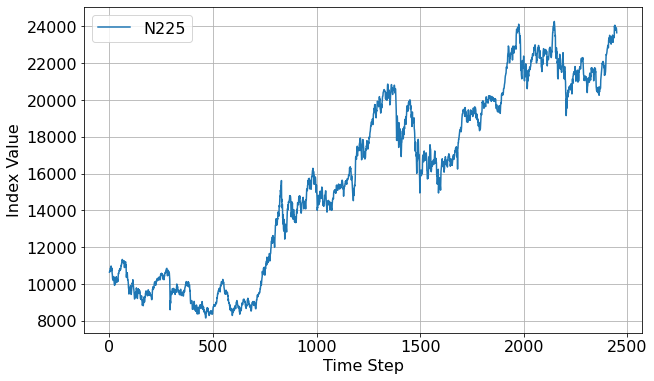

In [19]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME = np.array(time)
    SERIES = np.array(series)
    SPLIT_TIME = int((len(series)-150)*0.8)          # data splitting, the last 150 samples are test set.
    WINDOW_SIZE = 50                                # sequence length
    BATCH_SIZE = 32                                  # batch size

plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["N225"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/N225/figures/N225_original.svg")
plt.show()

## Processing the data

The `train_test_split` and `windowed_dataset` functions:

In [20]:
def train_test_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:-150]
    series_train = series[:-150]
    time_test = time[-150:]
    series_test = series[-150:]

    return time_train, series_train, time_test, series_test

# Split the dataset
time_train, series_train, time_test, series_test = train_test_split(G.TIME, G.SERIES)

In [21]:
def min_max_normalization(series):
  series = (series - min(series_train))/(max(series_train) - min(series_train))
  return series

In [22]:
series_norm = min_max_normalization(G.SERIES)

In [23]:
series_train_norm = series_norm[:-150]

series_test_norm = series_norm[-150:]

In [24]:
# Create train_set, val_set, and train_val_set. train_set and val_set are used for hyper=parameters tuning, and train_val_set is used for training.
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    #ds = ds.batch(batch_size).prefetch(1)
    return ds
#train_set = windowed_dataset(series_train_norm, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)
#cal_set = windowed_dataset(series_norm[G.SPLIT_TIME-G.WINDOW_SIZE:-150], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)
train_set = windowed_dataset(series_norm[0:-150], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [25]:
def bootstrap_dataset(train_set):
  
  biglist = list(train_set)
  bootstrap_list1 =[]
  bootstrap_list2 =[]
  features = []
  labels = []

  for i in range(len(biglist)):
    
    bootstrap_list1.append(random.choice(biglist))

  
    bootstrap_list2.append(list(bootstrap_list1[i]))

 
    features.append(bootstrap_list2[i][0])  

    labels.append(bootstrap_list2[i][1])

  features_tensor = tf.convert_to_tensor(features)
  labels_tensor = tf.convert_to_tensor(labels)

  features_constant = tf.constant(features_tensor)
  labels_constant = tf.constant(labels_tensor)

  bootstrap_dataset = tf.data.Dataset.from_tensor_slices((features_constant, labels_constant))
  bootstrap_dataset = bootstrap_dataset.batch(G.BATCH_SIZE).prefetch(1)

  return bootstrap_dataset

In [26]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()   
    rmse = tf.math.sqrt(mse).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    mape = tf.keras.metrics.mean_absolute_percentage_error(true_series, forecast).numpy()
    return rmse, mae, mape

In [27]:
# Define PICP (PI coverage probability)

def PICP(upper_bound, lower_bound, real_value):
  c = np.array(0)
  for i in range(len(real_value)):
    if ((real_value[i] <= upper_bound[i]) & (real_value[i] >= lower_bound[i])):
      c = c+1
  picp = c / len(real_value)
  return picp


In [28]:
# Define NMPIW (Normalized Mean PI width)

def NMPIW(upper_bound, lower_bound, real_value):
   return tf.reduce_mean(upper_bound - lower_bound) / (np.max(real_value)-np.min(real_value))

In [29]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [30]:
def reverse_normalization(series):
  series = series * (max(series_train) - min(series_train)) + min(series_train)
  return series

In [31]:
# Prepare callback

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.95,patience=5)

In [32]:
input_shape = (G.WINDOW_SIZE, 1)

In [33]:
# Define the number of bootstraps
num_bootstraps = 20
# Define alpha
alpha = 0.05

In [34]:
K.clear_session()

In [35]:
series_y = np.array(series[G.WINDOW_SIZE:])

# save time series
np.savetxt("/content/gdrive/MyDrive/N225/files/test_set_values_N225.csv", 
           series_test.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/N225/files/whole_values_N225.csv", 
           series_y.T, delimiter=",")

## Compiling the model


### Defining the model architecture (CapsNet-LSTM)


In [36]:
# Squash function

def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True) 
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


In [37]:
# Dynamic routing (layer)
#    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
#    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
#    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
#    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.

#    :param dim_capsule: dimension of the output vectors of the capsules in this layer
#    :param routings: number of iterations for the routing algorithm 

#@tf.keras.utils.register_keras_serializable() should use this line next time when need to save the model with a custom layer.
class Routing(keras.layers.Layer):

    def __init__(self, dim_capsule = 32 , routings=3, kernel_initializer='glorot_uniform'):
        super(Routing, self).__init__()
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        # build tansform matrix which can convert one primary cap to a vector with the same order as the digit cap.
        # assert len(input_shape) >= 3  # The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        
        # Transform matrix
       
        self.W = self.add_weight(shape=[self.input_num_capsule,self.dim_capsule, self.input_dim_capsule],initializer=self.kernel_initializer,name='W')

    def call(self, inputs): #training=None
        # inputs.shape=[input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[input_num_capsule, input_dim_capsule, 1]
        inputs_expand = K.expand_dims(inputs, -1)    

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[None, input_num_capsule, input_dim_capsule, 1]
        # W.shape=[input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first dimension as `batch` dimension,
        # then matmul: [dim_capsule, input_dim_capsule] x [input_dim_capsule, 1] -> [dim_capsule].
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule, 1]     
          
        inputs_hat = K.map_fn(lambda x: K.batch_dot(self.W, x, [2, 1]), elems=inputs_expand) 

        inputs_hat = K.squeeze(inputs_hat, axis = -1)
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule]
       
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.input_num_capsule])
        
        assert self.routings > 0
        for i in range(self.routings):
            # c.shape=[batch_size, input_num_capsule]
            c = tf.nn.softmax(b, axis=-1)

            # c.shape =  [batch_size, input_num_capsule]
            # inputs_hat.shape=[batch_size, input_num_capsule, dim_capsule]
            # The first dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, dim_capsule]
            
            #outputs = squash(K.batch_dot(c, inputs_hat, [1, 1])) 
            outputs = K.batch_dot(c, inputs_hat, [1, 1])

            if i < self.routings - 1:
                # outputs.shape =  [None, dim_capsule]
                # inputs_hat.shape=[None, input_num_capsule, dim_capsule]
                # The first dimension as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [1, 2])
       
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.dim_capsule])

    def get_config(self):
        config = super().get_config()
        config.update({
            "dim_capsule": self.dim_capsule,
            "routings": self.routings,
            "kernel_initializer": self.kernel_initializer,
        })
        return config

### Determine the number of Epoch

In [38]:
# Build the model with the default setting. LSTM units = 200, Convolution filters = 256, kernel size = 2, stride = 1, learning rate = 0.0005
def CapsNet_LSTM():
   
    input = tf.keras.layers.Input(shape=input_shape)
      
    # First layer
    conv1d_1 = tf.keras.layers.Conv1D(filters=256, kernel_size=2, strides=1, padding='causal', activation='relu', name = 'conv1d_1')(input)
          
    # Primary caps
  
    unsquashed_caps = tf.keras.layers.Reshape((G.WINDOW_SIZE, 32, 8))(conv1d_1)
    squashed_caps = tf.keras.layers.Lambda(squash)(unsquashed_caps)

    # Digit caps
     
    digit_caps = tf.keras.layers.TimeDistributed(Routing(dim_capsule = 256, routings = 3))(squashed_caps)

    # LSTM layer
    lstm = tf.keras.layers.LSTM(200)(digit_caps)

    # Dense layer

    output = tf.keras.layers.Dense(1)(lstm)

    model = keras.Model(inputs=input, outputs=output, name="capsnet_lstm")

    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

epoch number for CapsNet-LSTM is 500.

In [39]:
capsnet_lstm_ensemble = []
for i in range(num_bootstraps):
    with strategy.scope():
      capsnet_lstm = CapsNet_LSTM()
    # Fit with the entire dataset.
    capsnet_lstm.fit(bootstrap_dataset(train_set), epochs=200,callbacks = [reduce_lr],verbose = 0)  
    capsnet_lstm_ensemble.append(capsnet_lstm)

Instructions for updating:
Use fn_output_signature instead
Exception ignored in: <function Executor.__del__ at 0x7f99bc2b6280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7f99bc2b6280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignor

In [40]:
print(capsnet_lstm.summary())

Model: "capsnet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 256)           768       
                                                                 
 reshape_19 (Reshape)        (None, 50, 32, 8)         0         
                                                                 
 lambda_19 (Lambda)          (None, 50, 32, 8)         0         
                                                                 
 time_distributed_19 (TimeDi  (None, 50, 256)          65536     
 stributed)                                                      
                                                                 
 lstm_19 (LSTM)              (None, 200)               365600    
                                                      

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



### Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

In [41]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

capsnet_lstm_ensemble_pred = tf.reduce_mean([model_forecast(capsnet_lstm, series_norm, G.WINDOW_SIZE).squeeze() for capsnet_lstm in capsnet_lstm_ensemble], axis=0)

series_hat_capsnet_lstm = reverse_normalization(capsnet_lstm_ensemble_pred)

75/75 [==============================] - 10s 84ms/step


In [42]:
series_y_hat_capsnet_lstm = np.array(list(series_hat_capsnet_lstm[:-1]))

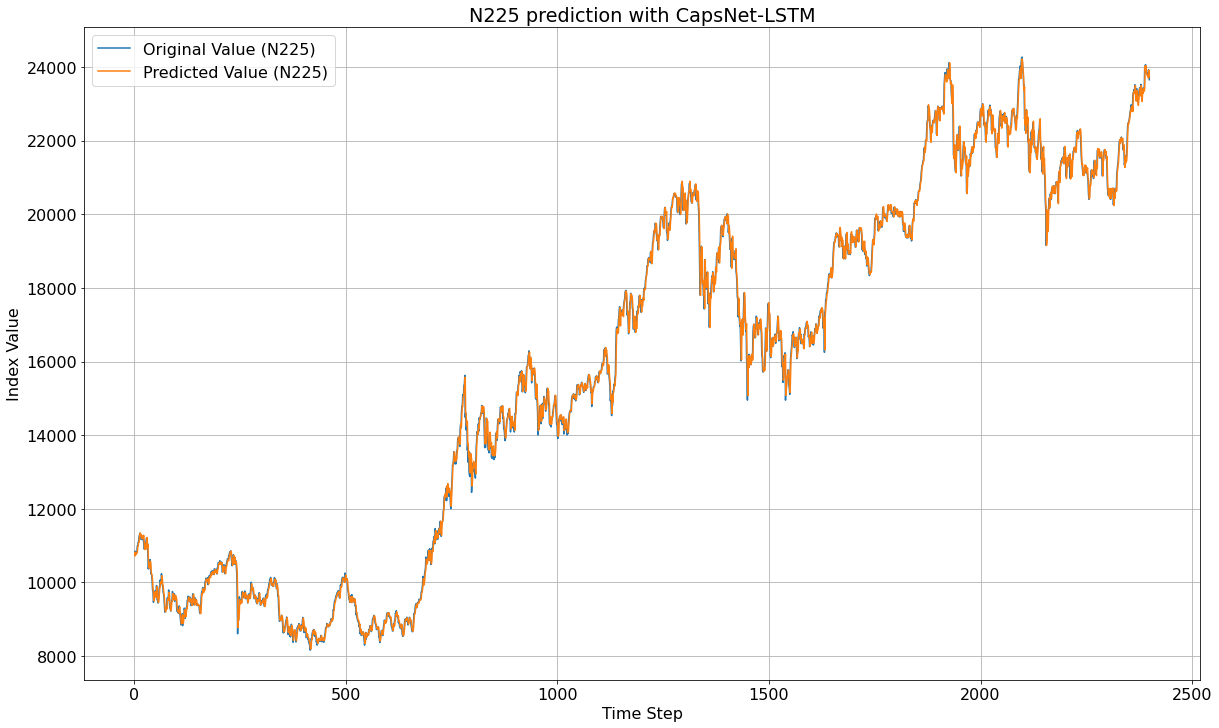

In [43]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_capsnet_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("N225 prediction with CapsNet-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (N225)", "Predicted Value (N225)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/N225/figures/capsnet_lstm_forecasts_whole_N225.svg")

In [44]:
# error series

abs_error_capsnet_lstm = np.abs(series_y-series_y_hat_capsnet_lstm)
series_test_hat_capsnet_lstm = series_y_hat_capsnet_lstm[-150:]
series_test_hat_capsnet_lstm_up = []
series_test_hat_capsnet_lstm_low = []

In [45]:
for i in range(len(series_test)):
  error = np.sort(abs_error_capsnet_lstm[i:i-len(series_test)], kind='quicksort')[::-1]
  up_bound = np.quantile(error, [0.95])
  low_bound = -np.quantile(error, [0.95])
  series_test_hat_capsnet_lstm_up.append(series_test_hat_capsnet_lstm[i] + up_bound)
  series_test_hat_capsnet_lstm_low.append(series_test_hat_capsnet_lstm[i] + low_bound)

In [46]:
series_test_hat_capsnet_lstm_up = np.array(series_test_hat_capsnet_lstm_up)
series_test_hat_capsnet_lstm_low = np.array(series_test_hat_capsnet_lstm_low)

In [47]:
series_test_hat_capsnet_lstm_up = np.squeeze(series_test_hat_capsnet_lstm_up)
series_test_hat_capsnet_lstm_low = np.squeeze(series_test_hat_capsnet_lstm_low)

In [48]:
bound_width_capsnet_lstm = series_test_hat_capsnet_lstm_up-series_test_hat_capsnet_lstm_low

In [49]:
PICP_capsnet_lstm = PICP(series_test_hat_capsnet_lstm_up, series_test_hat_capsnet_lstm_low, series_test)

In [50]:
PICP_capsnet_lstm

0.9533333333333334

In [51]:
NMPIW_capsnet_lstm = NMPIW(series_test_hat_capsnet_lstm_up, series_test_hat_capsnet_lstm_low, series_test)

In [52]:
NMPIW_capsnet_lstm

<tf.Tensor: shape=(), dtype=float64, numpy=0.22301994011952453>

In [53]:
rmse_capsnet_lstm, mae_capsnet_lstm, mape_capsnet_lstm= compute_metrics(series_test, series_test_hat_capsnet_lstm)

print(f"rmse: {rmse_capsnet_lstm:.2f}, mae: {mae_capsnet_lstm:.2f} , mape: {mape_capsnet_lstm:.2f} for forecast")

rmse: 175.57, mae: 130.82 , mape: 0.60 for forecast


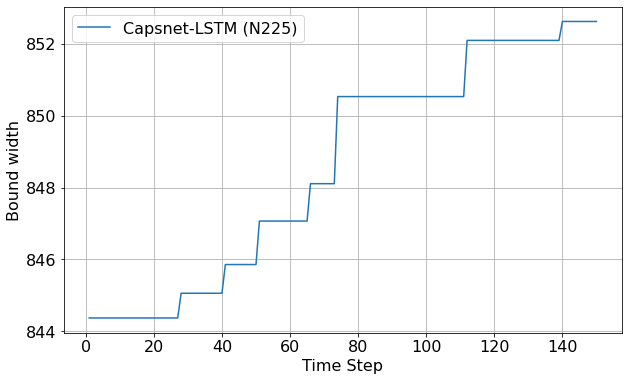

In [54]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_capsnet_lstm)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["Capsnet-LSTM (N225)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/N225/figures/capsnet_lstm_forecasts_bound_width_N225.svg")

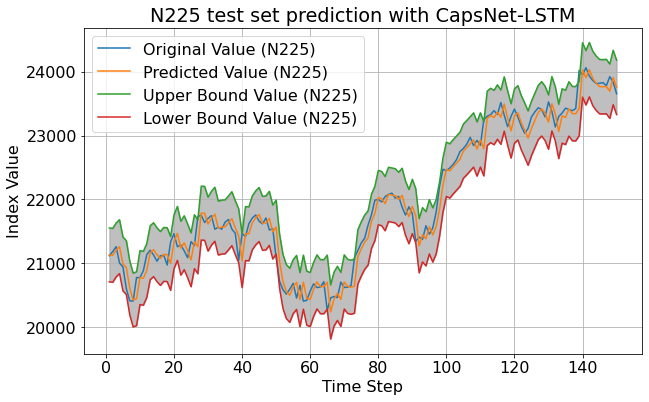

In [55]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_up, series_test_hat_capsnet_lstm_low, color='gray', alpha=0.5)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("N225 test set prediction with CapsNet-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (N225)", "Predicted Value (N225)", "Upper Bound Value (N225)", "Lower Bound Value (N225)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/N225/figures/capsnet_lstm_forecasts_bounds_N225.svg")

In [56]:
# Save_weights model

capsnet_lstm_ensemble[0].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_0.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[1].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_1.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[2].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_2.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[3].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_3.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[4].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_4.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[5].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_5.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[6].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_6.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[7].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_7.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[8].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_8.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[9].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_9.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[10].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_10.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[11].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_11.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[12].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_12.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[13].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_13.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[14].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_14.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[15].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_15.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[16].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_16.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[17].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_17.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[18].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_18.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[19].save_weights("/content/gdrive/MyDrive/N225/capsnet_lstm_ensemble/capsnet_lstm_N225_19.h5", overwrite=True, save_format=None, options=None)

In [57]:

capsnet_lstm.save_weights('/content/gdrive/MyDrive/N225/capsnet_lstm_N225_weights.h5', overwrite=True, save_format=None, options=None)

In [58]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/N225/capsnet_lstm_predicted_mean_N225.csv", 
           series_test_hat_capsnet_lstm.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/N225/capsnet_lstm_predicted_up_N225.csv", 
           series_test_hat_capsnet_lstm_up.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/N225/capsnet_lstm_predicted_low_N225.csv", 
           series_test_hat_capsnet_lstm_low.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/N225/capsnet_lstm_predicted_whole_N225.csv", 
           series_y_hat_capsnet_lstm.T, delimiter=",")

## Baseline (LSTM, CNN-LSTM)

### LSTM

In [59]:
# Build the model with the best hp.
def LSTM():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(200, input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

In [60]:
lstm_ensemble = []
for i in range(num_bootstraps):
    with strategy.scope():
      lstm = LSTM()
    # Fit with the entire dataset.
    lstm.fit(bootstrap_dataset(train_set), epochs=200,callbacks = [reduce_lr],verbose = 0)  
    lstm_ensemble.append(lstm)

Exception ignored in: <function Executor.__del__ at 0x7f99bc2b6280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7f99bc2b6280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7f99bc2b6280>
Traceb

In [61]:
print(lstm.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 200)               161600    
                                                                 
 dense_39 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

lstm_ensemble_pred = tf.reduce_mean([model_forecast(lstm, series_norm, G.WINDOW_SIZE).squeeze() for lstm in lstm_ensemble], axis=0)

series_hat_lstm = reverse_normalization(lstm_ensemble_pred)

75/75 [==============================] - 6s 39ms/step


In [63]:

series_y_hat_lstm = np.array(list(series_hat_lstm[:-1]))

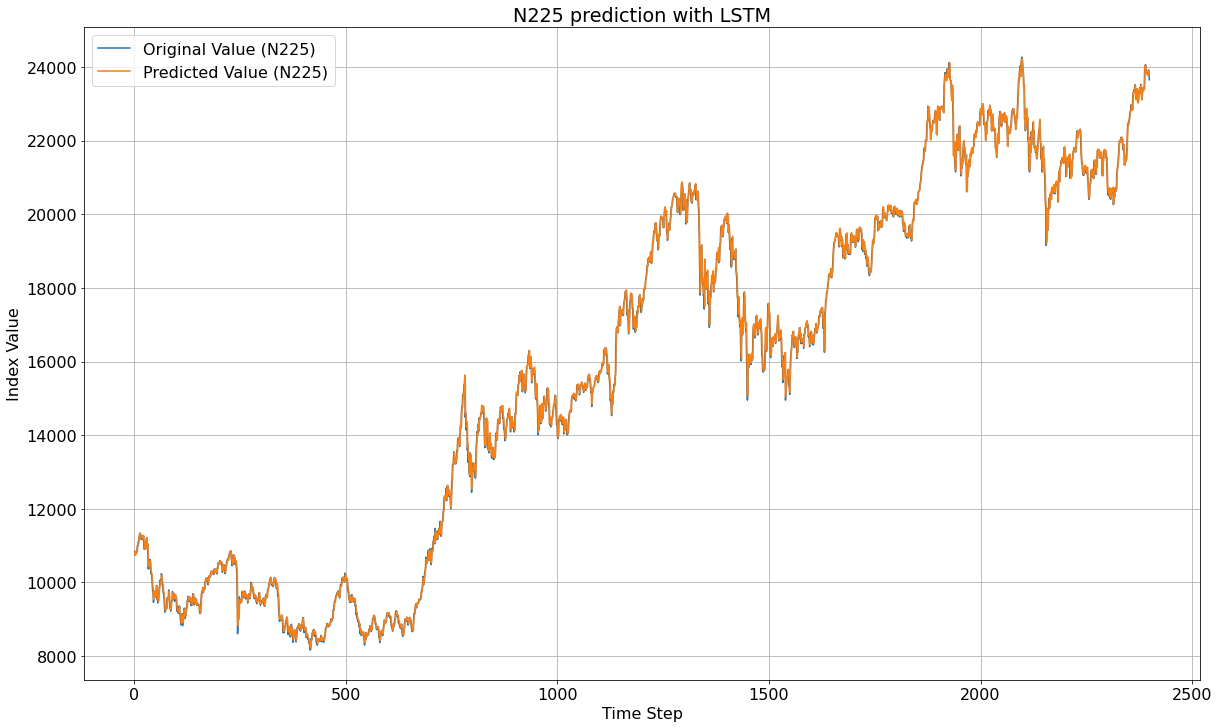

In [64]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("N225 prediction with LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (N225)", "Predicted Value (N225)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/N225/figures/lstm_forecasts_whole_N225.svg")

In [65]:
# error series

abs_error_lstm = np.abs(series_y-series_y_hat_lstm)
series_test_hat_lstm = series_y_hat_lstm[-150:]
series_test_hat_lstm_up = []
series_test_hat_lstm_low = []

In [66]:
for i in range(len(series_test)):
  error = np.sort(abs_error_lstm[i:i-len(series_test)], kind='quicksort')[::-1]
  up_bound = np.quantile(error, [0.95])
  low_bound = -np.quantile(error, [0.95])
  series_test_hat_lstm_up.append(series_test_hat_lstm[i] + up_bound)
  series_test_hat_lstm_low.append(series_test_hat_lstm[i] + low_bound)

In [67]:
series_test_hat_lstm_up = np.array(series_test_hat_lstm_up)
series_test_hat_lstm_low = np.array(series_test_hat_lstm_low)

In [68]:
series_test_hat_lstm_up = np.squeeze(series_test_hat_lstm_up)
series_test_hat_lstm_low = np.squeeze(series_test_hat_lstm_low)

In [69]:
bound_width_lstm = series_test_hat_lstm_up-series_test_hat_lstm_low

In [70]:
PICP_lstm = PICP(series_test_hat_lstm_up, series_test_hat_lstm_low, series_test)

In [71]:
PICP_lstm

0.96

In [72]:
NMPIW_lstm = NMPIW(series_test_hat_lstm_up, series_test_hat_lstm_low, series_test)

In [73]:
NMPIW_lstm

<tf.Tensor: shape=(), dtype=float64, numpy=0.22263496765070245>

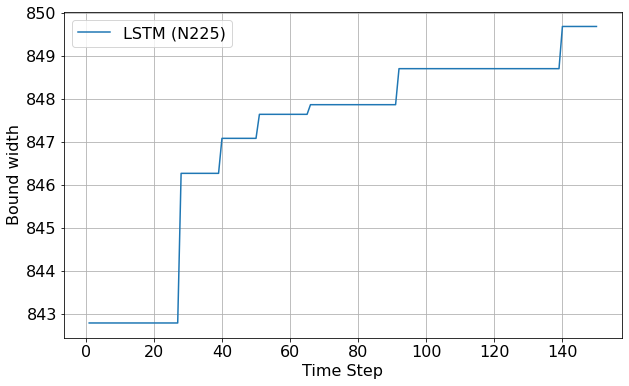

In [74]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_lstm)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["LSTM (N225)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/N225/figures/lstm_forecasts_bound_width_N225.svg")

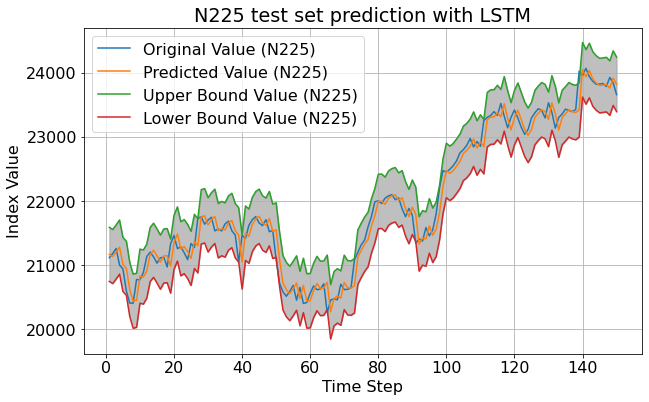

In [75]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_up, series_test_hat_lstm_low, color='gray', alpha=0.5)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("N225 test set prediction with LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (N225)", "Predicted Value (N225)", "Upper Bound Value (N225)", "Lower Bound Value (N225)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/N225/figures/lstm_forecasts_bounds_N225.svg")

In [76]:
rmse_lstm, mae_lstm, mape_lstm= compute_metrics(series_test, series_test_hat_lstm)

print(f"rmse: {rmse_lstm:.2f}, mae: {mae_lstm:.2f} , mape: {mape_lstm:.2f} for forecast")

rmse: 173.79, mae: 129.90 , mape: 0.60 for forecast


In [77]:
# Save model

lstm_ensemble[0].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_0.h5")
lstm_ensemble[1].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_1.h5")
lstm_ensemble[2].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_2.h5")
lstm_ensemble[3].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_3.h5")
lstm_ensemble[4].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_4.h5")
lstm_ensemble[5].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_5.h5")
lstm_ensemble[6].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_6.h5")
lstm_ensemble[7].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_7.h5")
lstm_ensemble[8].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_8.h5")
lstm_ensemble[9].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_9.h5")
lstm_ensemble[10].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_10.h5")
lstm_ensemble[11].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_11.h5")
lstm_ensemble[12].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_12.h5")
lstm_ensemble[13].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_13.h5")
lstm_ensemble[14].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_14.h5")
lstm_ensemble[15].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_15.h5")
lstm_ensemble[16].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_16.h5")
lstm_ensemble[17].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_17.h5")
lstm_ensemble[18].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_18.h5")
lstm_ensemble[19].save("/content/gdrive/MyDrive/N225/lstm_ensemble/lstm_N225_19.h5")


In [78]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/N225/lstm_predicted_mean_N225.csv", 
           series_test_hat_lstm.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/N225/lstm_predicted_up_N225.csv", 
           series_test_hat_lstm_up.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/N225/lstm_predicted_low_N225.csv", 
           series_test_hat_lstm_low.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/N225/lstm_predicted_whole_N225.csv", 
           series_y_hat_lstm.T, delimiter=",")

### CNN-LSTM

In [79]:
def CNN_LSTM():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=256, kernel_size=2,
                                 strides=1,
                                 activation="relu",
                                 padding='causal',
                                 input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
          tf.keras.layers.LSTM(200),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

Epoch number is 500.

In [80]:
cnn_lstm_ensemble = []
for i in range(num_bootstraps):
    with strategy.scope():
      cnn_lstm = CNN_LSTM()
    # Fit with the entire dataset.
    cnn_lstm.fit(bootstrap_dataset(train_set), epochs=200,callbacks = [reduce_lr],verbose = 0)  
    cnn_lstm_ensemble.append(cnn_lstm)

Exception ignored in: <function Executor.__del__ at 0x7f99bc2b6280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7f99bc2b6280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7f99bc2b6280>
Traceb

In [81]:
print(cnn_lstm.summary())

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 50, 256)           768       
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 50, 256)          0         
 g1D)                                                            
                                                                 
 lstm_59 (LSTM)              (None, 200)               365600    
                                                                 
 dense_59 (Dense)            (None, 1)                 201       
                                                                 
Total params: 366,569
Trainable params: 366,569
Non-trainable params: 0
_________________________________________________________________
None


In [82]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

cnn_lstm_ensemble_pred = tf.reduce_mean([model_forecast(cnn_lstm, series_norm, G.WINDOW_SIZE).squeeze() for cnn_lstm in cnn_lstm_ensemble], axis=0)

series_hat_cnn_lstm = reverse_normalization(cnn_lstm_ensemble_pred)

75/75 [==============================] - 5s 21ms/step


In [83]:
series_y_hat_cnn_lstm = np.array(list(series_hat_cnn_lstm[:-1]))

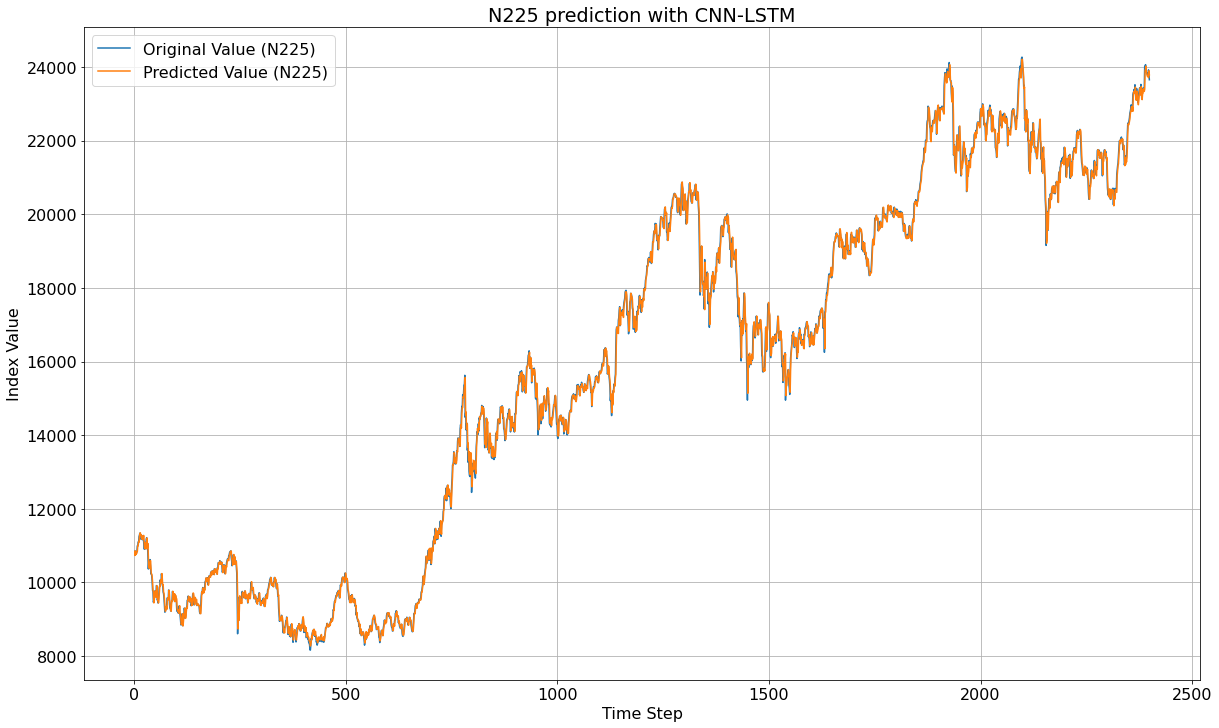

In [84]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_cnn_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("N225 prediction with CNN-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (N225)", "Predicted Value (N225)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/N225/figures/cnn_lstm_forecasts_whole_N225.svg")

In [85]:
# error series

abs_error_cnn_lstm = np.abs(series_y-series_y_hat_cnn_lstm)
series_test_hat_cnn_lstm = series_y_hat_cnn_lstm[-150:]
series_test_hat_cnn_lstm_up = []
series_test_hat_cnn_lstm_low = []

In [86]:
for i in range(len(series_test)):
  error = np.sort(abs_error_cnn_lstm[i:i-len(series_test)], kind='quicksort')[::-1]
  up_bound = np.quantile(error, [0.95])
  low_bound = -np.quantile(error, [0.95])
  series_test_hat_cnn_lstm_up.append(series_test_hat_cnn_lstm[i] + up_bound)
  series_test_hat_cnn_lstm_low.append(series_test_hat_cnn_lstm[i] + low_bound)

In [87]:
series_test_hat_cnn_lstm_up = np.array(series_test_hat_cnn_lstm_up)
series_test_hat_cnn_lstm_low = np.array(series_test_hat_cnn_lstm_low)

In [88]:
series_test_hat_cnn_lstm_up = np.squeeze(series_test_hat_cnn_lstm_up)
series_test_hat_cnn_lstm_low = np.squeeze(series_test_hat_cnn_lstm_low)

In [89]:
bound_width_cnn_lstm = series_test_hat_cnn_lstm_up-series_test_hat_cnn_lstm_low

In [90]:
PICP_cnn_lstm = PICP(series_test_hat_cnn_lstm_up, series_test_hat_cnn_lstm_low, series_test)

In [91]:
PICP_cnn_lstm

0.9666666666666667

In [92]:
NMPIW_cnn_lstm = NMPIW(series_test_hat_cnn_lstm_up, series_test_hat_cnn_lstm_low, series_test)

In [93]:
NMPIW_cnn_lstm

<tf.Tensor: shape=(), dtype=float64, numpy=0.21669099486191304>

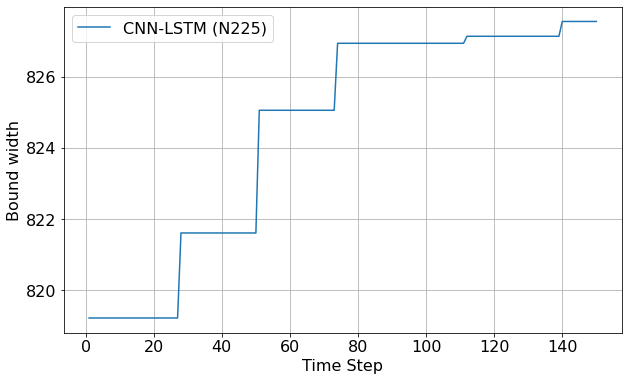

In [94]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_cnn_lstm)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["CNN-LSTM (N225)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/N225/figures/cnn_lstm_forecasts_bound_width_N225.svg")

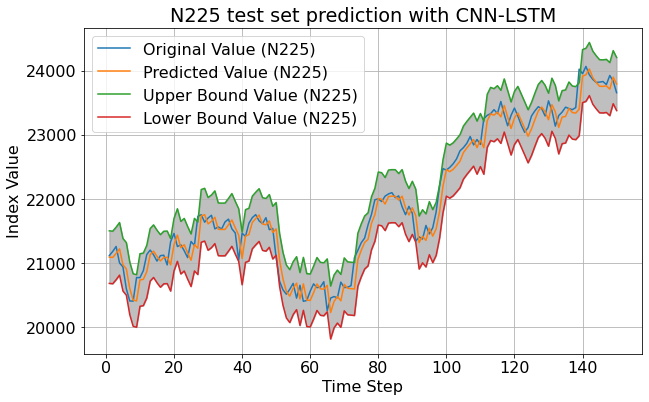

In [95]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_up, series_test_hat_cnn_lstm_low, color='gray', alpha=0.5)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("N225 test set prediction with CNN-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (N225)", "Predicted Value (N225)", "Upper Bound Value (N225)", "Lower Bound Value (N225)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/N225/figures/cnn_lstm_forecasts_bounds_N225.svg")

In [96]:
rmse_cnn_lstm, mae_cnn_lstm, mape_cnn_lstm= compute_metrics(series_test, series_test_hat_cnn_lstm)

print(f"rmse: {rmse_cnn_lstm:.2f}, mae: {mae_cnn_lstm:.2f} , mape: {mape_cnn_lstm:.2f} for forecast")

rmse: 177.84, mae: 133.89 , mape: 0.61 for forecast


In [97]:
# Save model

cnn_lstm_ensemble[0].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_0.h5")
cnn_lstm_ensemble[1].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_1.h5")
cnn_lstm_ensemble[2].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_2.h5")
cnn_lstm_ensemble[3].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_3.h5")
cnn_lstm_ensemble[4].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_4.h5")
cnn_lstm_ensemble[5].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_5.h5")
cnn_lstm_ensemble[6].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_6.h5")
cnn_lstm_ensemble[7].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_7.h5")
cnn_lstm_ensemble[8].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_8.h5")
cnn_lstm_ensemble[9].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_9.h5")
cnn_lstm_ensemble[10].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_10.h5")
cnn_lstm_ensemble[11].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_11.h5")
cnn_lstm_ensemble[12].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_12.h5")
cnn_lstm_ensemble[13].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_13.h5")
cnn_lstm_ensemble[14].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_14.h5")
cnn_lstm_ensemble[15].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_15.h5")
cnn_lstm_ensemble[16].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_16.h5")
cnn_lstm_ensemble[17].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_17.h5")
cnn_lstm_ensemble[18].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_18.h5")
cnn_lstm_ensemble[19].save("/content/gdrive/MyDrive/N225/cnn_lstm_ensemble/cnn_lstm_N225_19.h5")

# Plot together

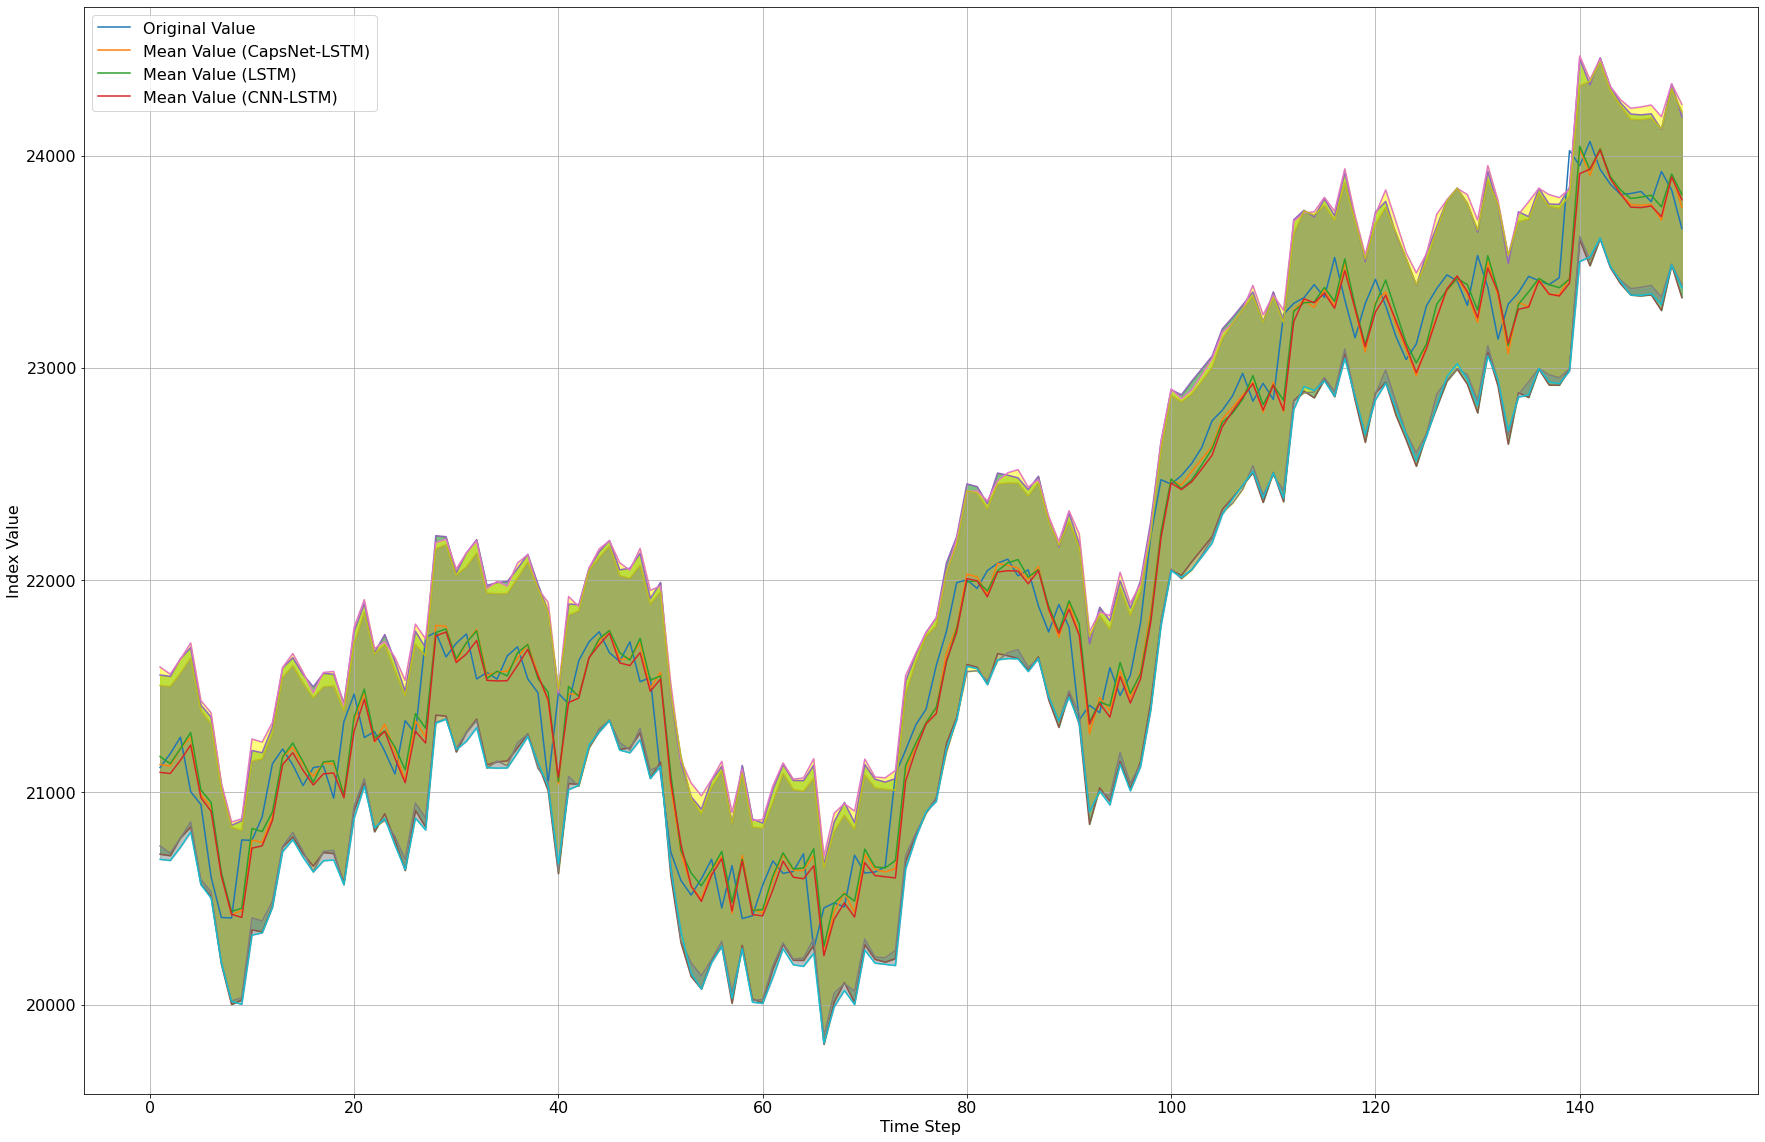

In [98]:
plt.figure(figsize=(30, 20))
plt.rcParams['font.size'] = '16'
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm)

plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_up, series_test_hat_capsnet_lstm_low, color='green', alpha=0.5)

plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_up, series_test_hat_lstm_low, color='yellow', alpha=0.5)

plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_up, series_test_hat_cnn_lstm_low, color='gray', alpha=0.5)


plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["Original Value", "Mean Value (CapsNet-LSTM)","Mean Value (LSTM)","Mean Value (CNN-LSTM)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/N225/all_together_forecasts_N225.svg")

In [99]:
print(rmse_capsnet_lstm)
print(rmse_lstm)
print(rmse_cnn_lstm)

175.57426
173.7949
177.84232


In [100]:
print(mae_capsnet_lstm)
print(mae_lstm)
print(mae_cnn_lstm)

130.81726
129.89969
133.88843


In [101]:
print(mape_capsnet_lstm)
print(mape_lstm)
print(mape_cnn_lstm)

0.5996742
0.5957984
0.61364436


In [102]:
print(PICP_capsnet_lstm)
print(PICP_lstm)
print(PICP_cnn_lstm)

0.9533333333333334
0.96
0.9666666666666667


In [103]:
print(NMPIW_capsnet_lstm)
print(NMPIW_lstm)
print(NMPIW_cnn_lstm)

tf.Tensor(0.22301994011952453, shape=(), dtype=float64)
tf.Tensor(0.22263496765070245, shape=(), dtype=float64)
tf.Tensor(0.21669099486191304, shape=(), dtype=float64)


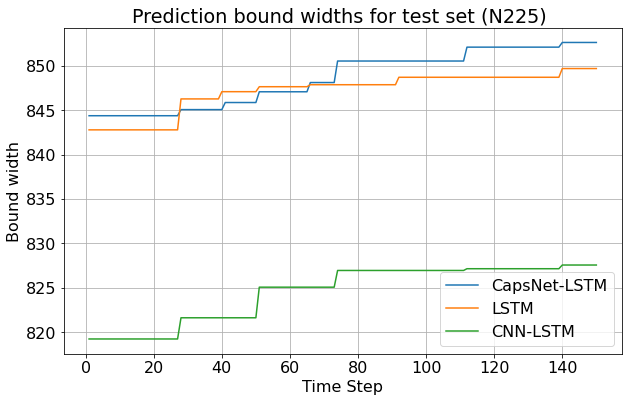

In [104]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_capsnet_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_cnn_lstm)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
plt.title("Prediction bound widths for test set (N225) ")
legend_drawn_flag = True
plt.legend(["CapsNet-LSTM","LSTM","CNN-LSTM"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/N225/figures/lstm_forecasts_all_bound_widths_N225.svg")